In [6]:
import os
import re
import math
import pickle
import random
import numpy as np
import pandas as pd
import matplotlib as mpl
import matplotlib.pyplot as plt
from time import sleep, time
from sklearn import preprocessing, svm
from sklearn.linear_model import Ridge, RidgeClassifier, RidgeClassifierCV, PassiveAggressiveClassifier, PassiveAggressiveRegressor, LinearRegression, HuberRegressor
from sklearn.model_selection import train_test_split, LeaveOneOut
from sklearn.metrics import mean_squared_error, r2_score, accuracy_score
from sklearn.preprocessing import PolynomialFeatures, FunctionTransformer, StandardScaler
from sklearn.pipeline import make_pipeline
from sklearn.tree import DecisionTreeRegressor
from sklearn.ensemble import RandomForestClassifier

In [7]:
def add_squared_col(X):
    return np.hstack((X, X**2))
marker = ['^','<','>','*','D','P']

In [8]:
col_types = {'Age': np.int32, 'Potential': np.int32, 'Overall': np.int32}
ff18 = pd.read_csv('data/Dataset.csv', usecols=['Name', 'Nationality', 'Club', 'Photo', 'Value', 'Age', 'Wage', 'Potential', 'Overall', 'Finishing', 'Penalties', 'Aggression', 'Crossing', 'Stamina', 'Dribbling'], dtype=col_types)


In [9]:
def finishing(s):
    try:
        n = int(s)
        return (1 <= n and n <= 99)
    except:
        return False

In [10]:
cols_int = ['Age', 'Potential', 'Finishing', 'Penalties', 'Aggression', 'Crossing', 'Stamina', 'Dribbling']
for col in cols_int:
    ff18 = ff18.loc[ff18[col].apply(lambda x: finishing(x))]
    ff18[col] = ff18[col].astype('int')

In [11]:
ff18.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 13450 entries, 0 to 13499
Data columns (total 15 columns):
Name           13450 non-null object
Age            13450 non-null int64
Photo          13450 non-null object
Nationality    13450 non-null object
Overall        13450 non-null int32
Potential      13450 non-null int64
Club           13156 non-null object
Value          13450 non-null object
Wage           13450 non-null object
Aggression     13450 non-null int64
Crossing       13450 non-null int64
Dribbling      13450 non-null int64
Finishing      13450 non-null int64
Penalties      13450 non-null int64
Stamina        13450 non-null int64
dtypes: int32(1), int64(8), object(6)
memory usage: 1.6+ MB


In [12]:
def str2number(amount):
    if amount[-1] == 'M':
        amount = float(re.sub('[^\d\.]', '', amount))
        return float(amount)*1000000
    elif amount[-1] == 'K':
        amount = float(re.sub('[^\d\.]', '', amount))
        return float(amount)*1000
    else:
        amount = float(re.sub('[^\d\.]', '', amount))
        return float(amount)
ff18['ValueNum'] = ff18['Value'].apply(lambda x: str2number(x))

In [13]:
ff18.head(1).T

,0
Name,A. Mac Allister
Age,19
Photo,https://cdn.sofifa.org/players/4/19/239837.png
Nationality,Argentina
Overall,72
Potential,86
Club,Argentinos Juniors
Value,€6.5M
Wage,€15K
Aggression,51


In [14]:
ff18.describe()

,Age,Overall,Potential,Aggression,Crossing,Dribbling,Finishing,Penalties,Stamina,ValueNum
count,13450.000000,13450.000000,13450.000000,13450.000000,13450.000000,13450.000000,13450.000000,13450.000000,13450.000000,1.345000e+04
mean,23.567361,64.615093,71.365204,62.478067,60.861784,69.426691,57.467138,56.877100,70.871301,2.388358e+06
std,4.944073,8.325004,6.880788,17.022906,18.157202,17.118622,19.742950,15.698025,13.451245,5.717896e+06
min,15.000000,31.000000,31.000000,13.000000,9.000000,5.000000,3.000000,10.000000,14.000000,0.000000e+00
25%,20.000000,58.000000,67.000000,51.000000,52.000000,65.000000,45.000000,46.000000,66.000000,1.600000e+05
50%,22.000000,64.000000,71.000000,66.000000,66.000000,74.000000,63.000000,59.000000,73.000000,5.250000e+05
75%,27.000000,71.000000,76.000000,76.000000,74.000000,80.000000,73.000000,68.000000,79.000000,1.800000e+06
max,47.000000,94.000000,95.000000,95.000000,93.000000,96.000000,94.000000,92.000000,97.000000,1.080000e+08


In [15]:
ff18.Overall.describe()

count    13450.000000
mean        64.615093
std          8.325004
min         31.000000
25%         58.000000
50%         64.000000
75%         71.000000
max         94.000000
Name: Overall, dtype: float64

In [16]:
ff18 = ff18.loc[ff18.ValueNum > 0]

In [17]:
ff18.head(5)

,Name,Age,Photo,Nationality,Overall,Potential,Club,Value,Wage,Aggression,Crossing,Dribbling,Finishing,Penalties,Stamina,ValueNum
0,A. Mac Allister,19,https://cdn.sofifa.org/players/4/19/239837.png,Argentina,72,86,Argentinos Juniors,€6.5M,€15K,51,72,73,76,74,69,6500000.0
1,K. Asamoah,29,https://cdn.sofifa.org/players/4/19/186832.png,Ghana,79,79,Inter,€9.5M,€62K,82,78,82,55,64,76,9500000.0
2,P. Dybala,24,https://cdn.sofifa.org/players/4/19/211110.png,Argentina,89,94,Juventus,€89M,€205K,48,82,92,82,86,80,89000000.0
3,A. Saint-Maximin,21,https://cdn.sofifa.org/players/4/19/216388.png,France,79,86,OGC Nice,€18M,€31K,36,66,89,70,47,77,18000000.0
4,Bruno Fernandes,23,https://cdn.sofifa.org/players/4/19/212198.png,Portugal,85,89,Sporting CP,€50M,€24K,70,85,85,78,86,91,50000000.0


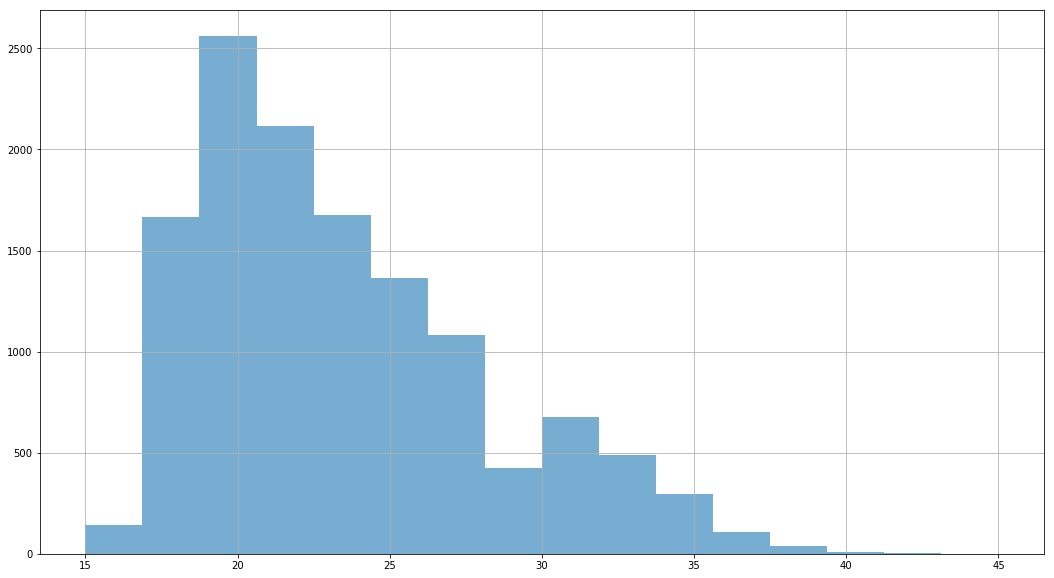

In [18]:
plt.figure(figsize=(18, 10))
plt.grid(True)
ff18.Age.hist(bins=16, alpha=.6)
plt.show()

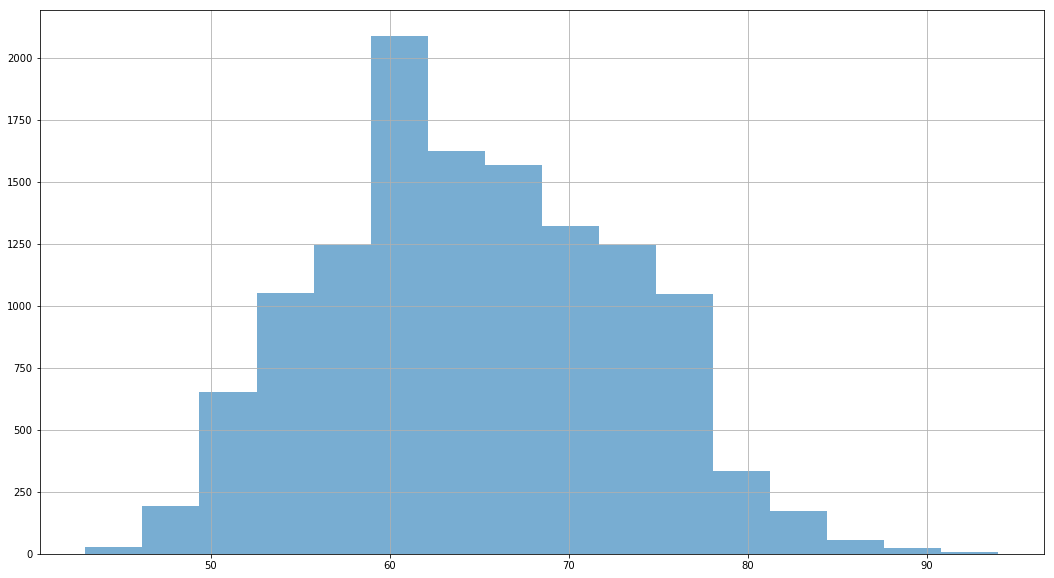

In [19]:
plt.figure(figsize=(18, 10))
ff18.Overall.hist(bins=16, alpha=.6)
plt.grid(True)
plt.show()

In [20]:
# building our predictive model
train, test = train_test_split(ff18, test_size=0.4, random_state=45)

xtrain = train[['ValueNum', 'Age', 'Finishing', 'Aggression', 'Crossing', 'Stamina', 'Dribbling']]
ytrain = train[['Overall']]
xtest = test[['ValueNum', 'Age', 'Finishing', 'Aggression', 'Crossing', 'Stamina', 'Dribbling']]
ytest = test[['Overall']]

In [21]:
print("Players less than 30 Million Euro {:.2f}%".format(test.loc[test.ValueNum <= 30000000].ValueNum.count().astype('float') / test.ValueNum.count().astype('float') * 100))

Players less than 30 Million Euro 99.21%


In [22]:
def pickeling(name, engine):
    pickle.HIGHEST_PROTOCOL
    f = "./pkl/{}.pickle".format(name).lower()
    if os.path.isfile(f):
        with open(f, "rb") as fh:
            u = pickle._Unpickler(fh)
            u.encoding = 'latin1'
            p = u.load()
        print("returning pickle load {} {}".format(name, time()))
        return p
    else:
        print("building clf {} {}".format(name, time()))
        clf = make_pipeline(StandardScaler(), FunctionTransformer(add_squared_col), engine)
        with open(f, "wb") as d:
            pickle.dump(clf, d)
            d.flush()
            d.close()
        sleep(5)
    pickeling(name, engine)

/opt/conda/lib/python3.7/site-packages/sklearn/base.py:253: UserWarning: Trying to unpickle estimator StandardScaler from version 0.19.1 when using version 0.20.3. This might lead to breaking code or invalid results. Use at your own risk.
  UserWarning)
/opt/conda/lib/python3.7/site-packages/sklearn/base.py:253: UserWarning: Trying to unpickle estimator SVR from version 0.19.1 when using version 0.20.3. This might lead to breaking code or invalid results. Use at your own risk.
  UserWarning)
/opt/conda/lib/python3.7/site-packages/sklearn/base.py:253: UserWarning: Trying to unpickle estimator Pipeline from version 0.19.1 when using version 0.20.3. This might lead to breaking code or invalid results. Use at your own risk.
  UserWarning)
/opt/conda/lib/python3.7/site-packages/sklearn/preprocessing/data.py:645: DataConversionWarning: Data with input dtype int64, float64 were all converted to float64 by StandardScaler.
  return self.partial_fit(X, y)
/opt/conda/lib/python3.7/site-packages/s

returning pickle load RBF 1564126489.2344825


/opt/conda/lib/python3.7/site-packages/sklearn/pipeline.py:331: DataConversionWarning: Data with input dtype int64, float64 were all converted to float64 by StandardScaler.
  Xt = transform.transform(Xt)
/opt/conda/lib/python3.7/site-packages/sklearn/pipeline.py:511: DataConversionWarning: Data with input dtype int64, float64 were all converted to float64 by StandardScaler.
  Xt = transform.transform(Xt)


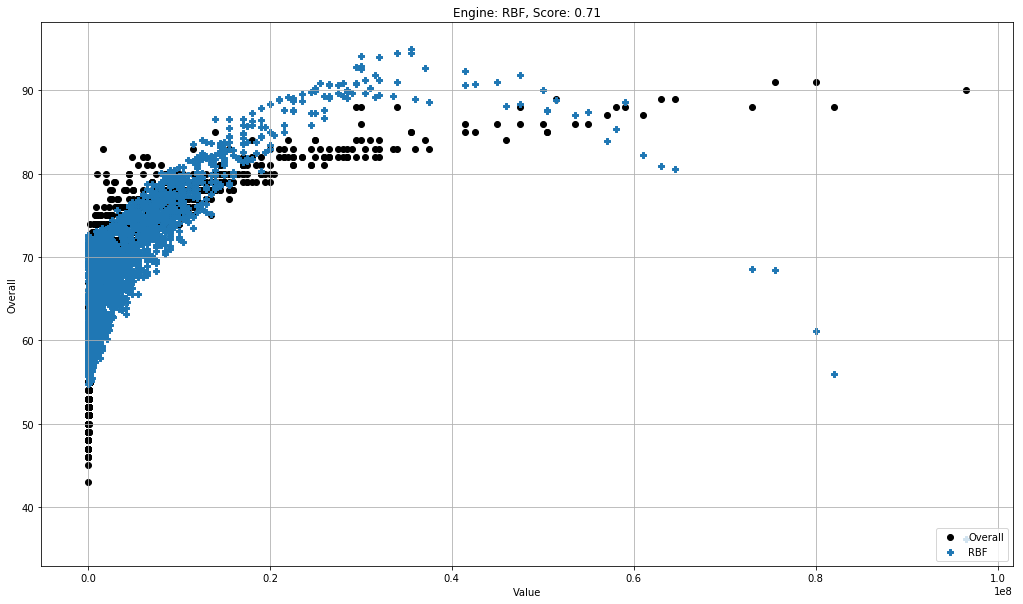

/opt/conda/lib/python3.7/site-packages/sklearn/base.py:253: UserWarning: Trying to unpickle estimator StandardScaler from version 0.19.1 when using version 0.20.3. This might lead to breaking code or invalid results. Use at your own risk.
  UserWarning)
/opt/conda/lib/python3.7/site-packages/sklearn/base.py:253: UserWarning: Trying to unpickle estimator DecisionTreeRegressor from version 0.19.1 when using version 0.20.3. This might lead to breaking code or invalid results. Use at your own risk.
  UserWarning)
/opt/conda/lib/python3.7/site-packages/sklearn/base.py:253: UserWarning: Trying to unpickle estimator Pipeline from version 0.19.1 when using version 0.20.3. This might lead to breaking code or invalid results. Use at your own risk.
  UserWarning)
/opt/conda/lib/python3.7/site-packages/sklearn/preprocessing/data.py:645: DataConversionWarning: Data with input dtype int64, float64 were all converted to float64 by StandardScaler.
  return self.partial_fit(X, y)
/opt/conda/lib/python3

returning pickle load DTR 1564126496.417037


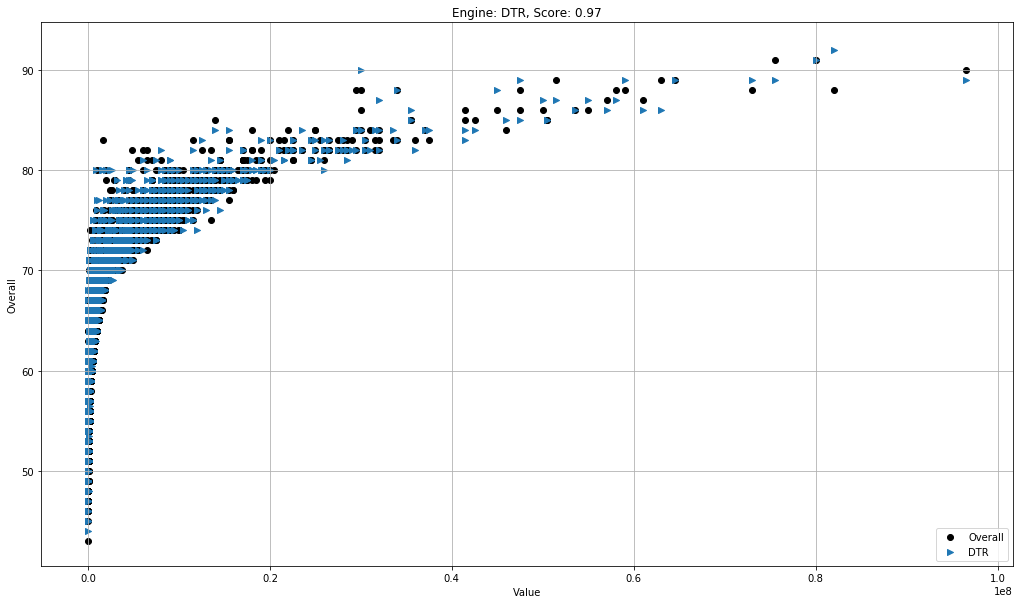

/opt/conda/lib/python3.7/site-packages/sklearn/base.py:253: UserWarning: Trying to unpickle estimator StandardScaler from version 0.19.1 when using version 0.20.3. This might lead to breaking code or invalid results. Use at your own risk.
  UserWarning)
/opt/conda/lib/python3.7/site-packages/sklearn/base.py:253: UserWarning: Trying to unpickle estimator Ridge from version 0.19.1 when using version 0.20.3. This might lead to breaking code or invalid results. Use at your own risk.
  UserWarning)
/opt/conda/lib/python3.7/site-packages/sklearn/base.py:253: UserWarning: Trying to unpickle estimator Pipeline from version 0.19.1 when using version 0.20.3. This might lead to breaking code or invalid results. Use at your own risk.
  UserWarning)
/opt/conda/lib/python3.7/site-packages/sklearn/preprocessing/data.py:645: DataConversionWarning: Data with input dtype int64, float64 were all converted to float64 by StandardScaler.
  return self.partial_fit(X, y)
/opt/conda/lib/python3.7/site-packages

returning pickle load Ridge 1564126496.9680166


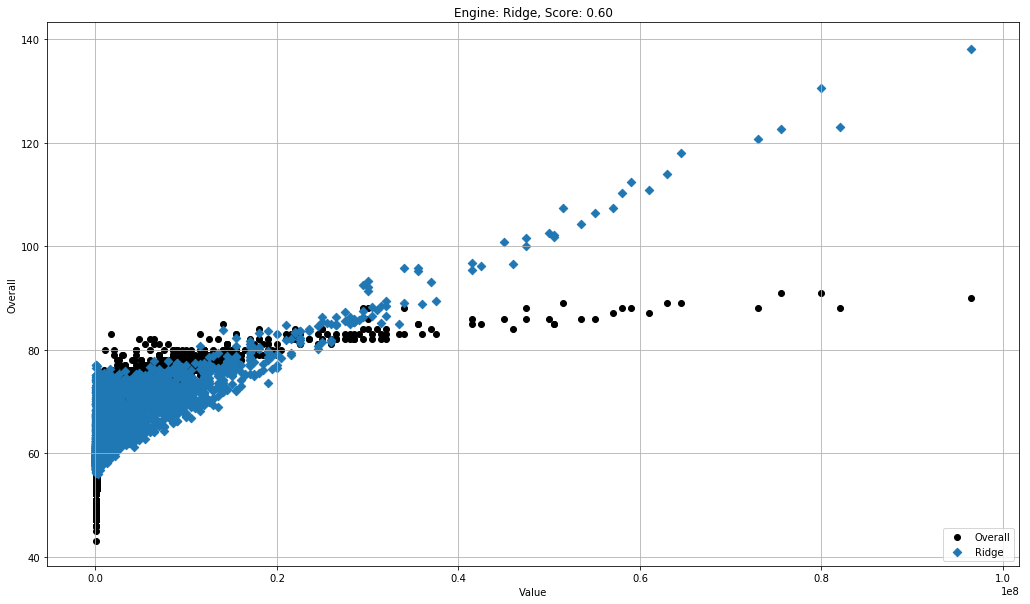

returning pickle load RC 1564126497.5218177


/opt/conda/lib/python3.7/site-packages/sklearn/preprocessing/data.py:645: DataConversionWarning: Data with input dtype int64, float64 were all converted to float64 by StandardScaler.
  return self.partial_fit(X, y)
/opt/conda/lib/python3.7/site-packages/sklearn/base.py:467: DataConversionWarning: Data with input dtype int64, float64 were all converted to float64 by StandardScaler.
  return self.fit(X, y, **fit_params).transform(X)
/opt/conda/lib/python3.7/site-packages/sklearn/preprocessing/_function_transformer.py:98: FutureWarning: The default validate=True will be replaced by validate=False in 0.22.
  "validate=False in 0.22.", FutureWarning)
/opt/conda/lib/python3.7/site-packages/sklearn/preprocessing/_function_transformer.py:98: FutureWarning: The default validate=True will be replaced by validate=False in 0.22.
  "validate=False in 0.22.", FutureWarning)
/opt/conda/lib/python3.7/site-packages/sklearn/pipeline.py:331: DataConversionWarning: Data with input dtype int64, float64 wer

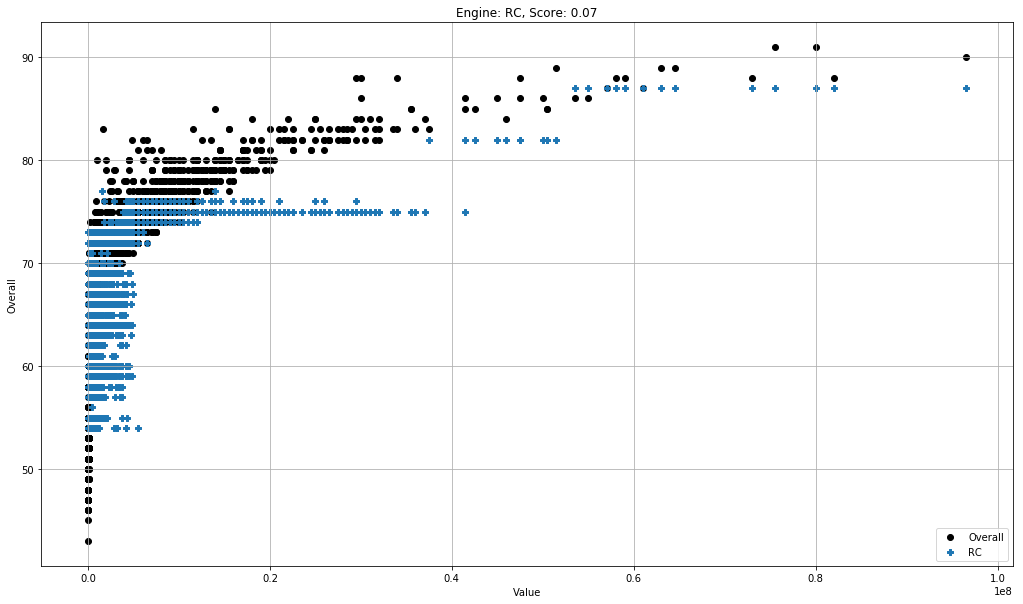

returning pickle load RCCV 1564126498.0480158


/opt/conda/lib/python3.7/site-packages/sklearn/preprocessing/data.py:645: DataConversionWarning: Data with input dtype int64, float64 were all converted to float64 by StandardScaler.
  return self.partial_fit(X, y)
/opt/conda/lib/python3.7/site-packages/sklearn/base.py:467: DataConversionWarning: Data with input dtype int64, float64 were all converted to float64 by StandardScaler.
  return self.fit(X, y, **fit_params).transform(X)
/opt/conda/lib/python3.7/site-packages/sklearn/preprocessing/_function_transformer.py:98: FutureWarning: The default validate=True will be replaced by validate=False in 0.22.
  "validate=False in 0.22.", FutureWarning)
/opt/conda/lib/python3.7/site-packages/sklearn/preprocessing/_function_transformer.py:98: FutureWarning: The default validate=True will be replaced by validate=False in 0.22.
  "validate=False in 0.22.", FutureWarning)
/opt/conda/lib/python3.7/site-packages/sklearn/pipeline.py:331: DataConversionWarning: Data with input dtype int64, float64 wer

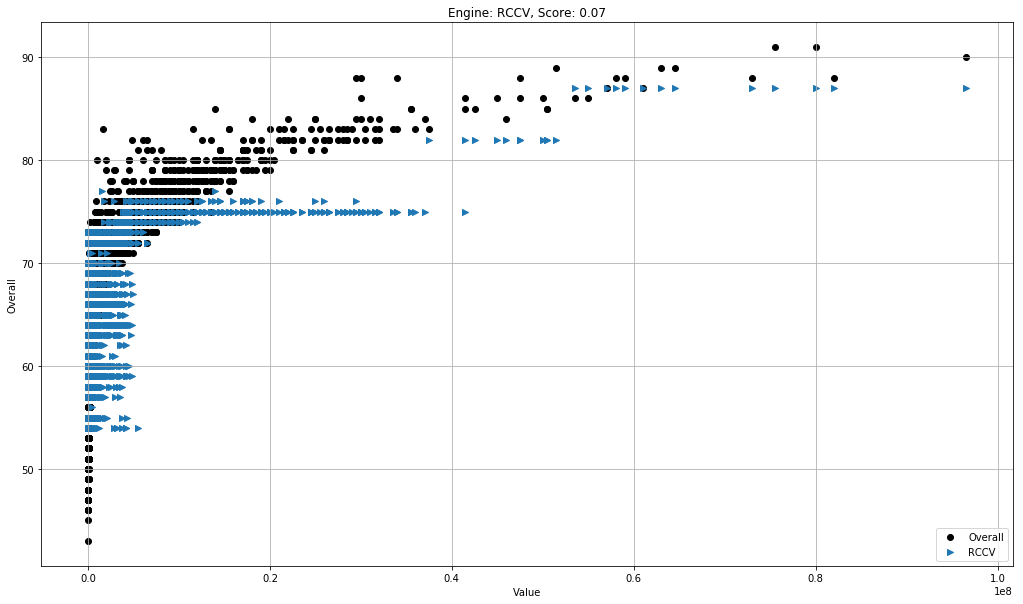

/opt/conda/lib/python3.7/site-packages/sklearn/base.py:253: UserWarning: Trying to unpickle estimator StandardScaler from version 0.19.1 when using version 0.20.3. This might lead to breaking code or invalid results. Use at your own risk.
  UserWarning)
/opt/conda/lib/python3.7/site-packages/sklearn/base.py:253: UserWarning: Trying to unpickle estimator LinearRegression from version 0.19.1 when using version 0.20.3. This might lead to breaking code or invalid results. Use at your own risk.
  UserWarning)
/opt/conda/lib/python3.7/site-packages/sklearn/base.py:253: UserWarning: Trying to unpickle estimator Pipeline from version 0.19.1 when using version 0.20.3. This might lead to breaking code or invalid results. Use at your own risk.
  UserWarning)
/opt/conda/lib/python3.7/site-packages/sklearn/preprocessing/data.py:645: DataConversionWarning: Data with input dtype int64, float64 were all converted to float64 by StandardScaler.
  return self.partial_fit(X, y)
/opt/conda/lib/python3.7/si

returning pickle load LR 1564126498.671511


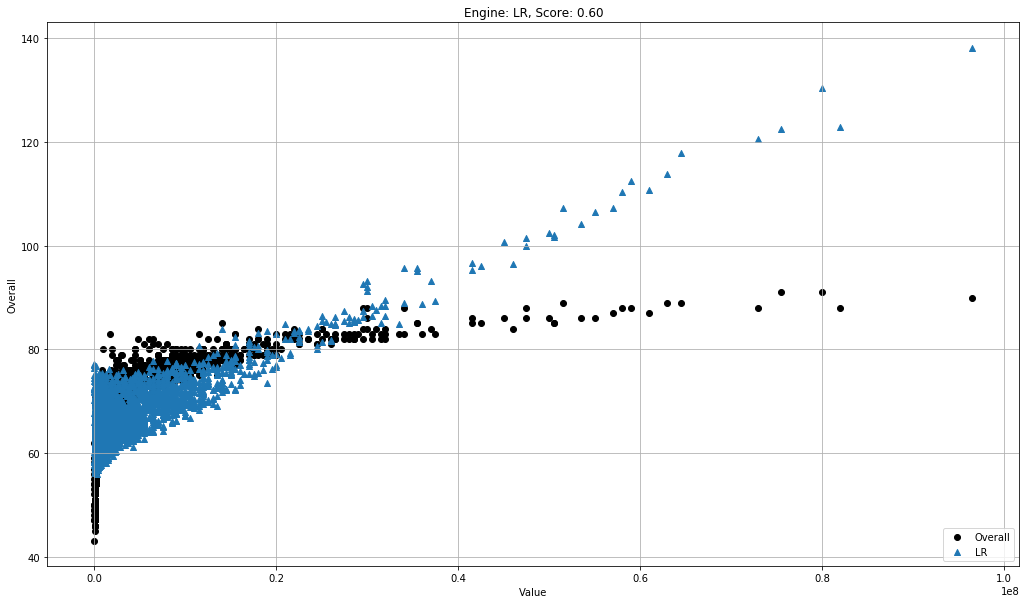

/opt/conda/lib/python3.7/site-packages/sklearn/base.py:253: UserWarning: Trying to unpickle estimator StandardScaler from version 0.19.1 when using version 0.20.3. This might lead to breaking code or invalid results. Use at your own risk.
  UserWarning)
/opt/conda/lib/python3.7/site-packages/sklearn/base.py:253: UserWarning: Trying to unpickle estimator HuberRegressor from version 0.19.1 when using version 0.20.3. This might lead to breaking code or invalid results. Use at your own risk.
  UserWarning)
/opt/conda/lib/python3.7/site-packages/sklearn/base.py:253: UserWarning: Trying to unpickle estimator Pipeline from version 0.19.1 when using version 0.20.3. This might lead to breaking code or invalid results. Use at your own risk.
  UserWarning)
/opt/conda/lib/python3.7/site-packages/sklearn/preprocessing/data.py:645: DataConversionWarning: Data with input dtype int64, float64 were all converted to float64 by StandardScaler.
  return self.partial_fit(X, y)
/opt/conda/lib/python3.7/site

returning pickle load HR 1564126499.2509053


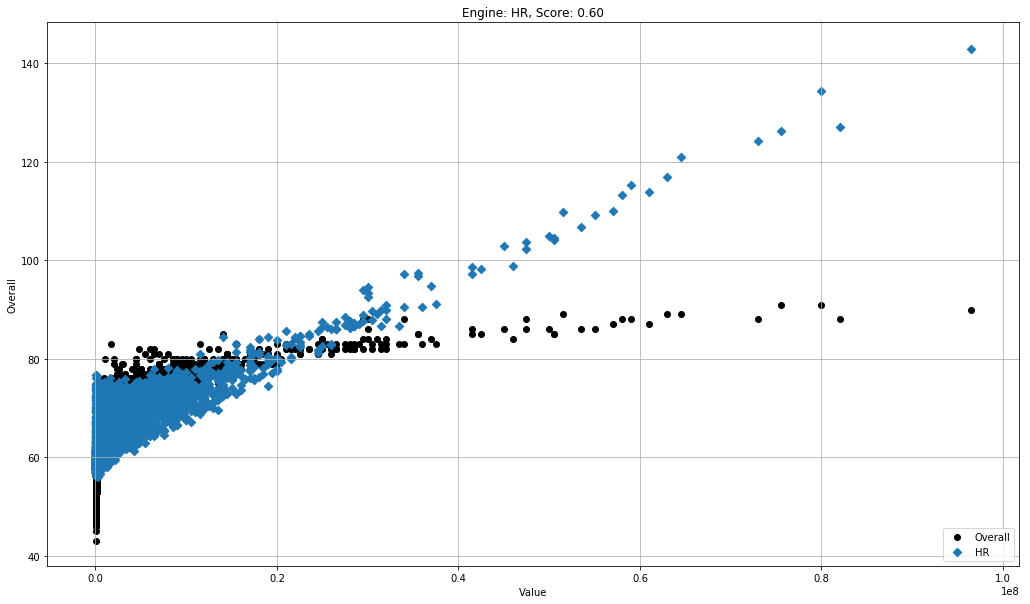

In [23]:
# Be patient this might take few minutes ;)
# Support Vector Regression - RBF (radial basis function)
# PolynomialFeatures and Ridge Regression
results  = []
ypred    = []
i        = 0
engines  = [('RBF', svm.SVR(kernel='rbf', gamma=1e-3, C=100, epsilon=0.1)),
           ('DTR', DecisionTreeRegressor()),
           ('Ridge', Ridge()),
           ('RC', RidgeClassifier()),
           ('RCCV', RidgeClassifierCV()),
           ('LR', LinearRegression(normalize=True)),
           ('HR', HuberRegressor(alpha=1.3, epsilon=4.4, tol=1e-4))]
for name, engine in engines:
#     clf = make_pipeline(StandardScaler(), FunctionTransformer(add_squared_col), engine)
    clf = pickeling(name,engine)
    clf.fit(xtrain, ytrain.values.ravel())
    ypred = clf.predict(xtest)
    
    results.append({"Engine": name, "Mean squared error": mean_squared_error(ytest, ypred),
         "Variance core": r2_score(ytest, ypred), "Accuracy score": clf.score(xtest, ytest),
          "predict": ypred})
    
    plt.figure(figsize=(18, 10))
    plt.scatter(xtest['ValueNum'], ytest['Overall'], linewidth=1, color='black')
    plt.scatter(xtest['ValueNum'], ypred, linewidth=1, label=name, marker=random.choice(marker))
    plt.xlabel("Value")
    plt.ylabel("Overall")
    plt.legend(loc='lower right')
    plt.grid(True)
    plt.title("Engine: {}, Score: {:.2f}".format(results[i]['Engine'], results[i]['Accuracy score']))
    #plt.text(2, 0.65, str(results[i]), fontsize=16)
    plt.subplots_adjust(left=0.15)
    plt.draw()
    plt.show()
    i += 1

>This may seem like this model is not very good, but, in this case we can accept a model that produces a few bad predictions, with the most of them being good, then this model is not as bad as we thought. That’s because the predictions seem to be pretty accurate for those players with a value lower than €30M. Although it can not be appreciated very well in the plot, those players represent 98.97% of the total!

In [24]:
pd.options.mode.chained_assignment = None

# minimum score we are willing to accept
min_score = 0.9

for result in results:
    if result['Accuracy score'] < min_score: continue
    test['Overall_{}'.format(result['Engine'])] = result['predict']
    test['Error_PCT_{}'.format(result['Engine'])] = np.abs((test.Overall - result['predict']) / test.Overall * 100)

> Update *test* DataFrame, add new columns from classifier and prediction 

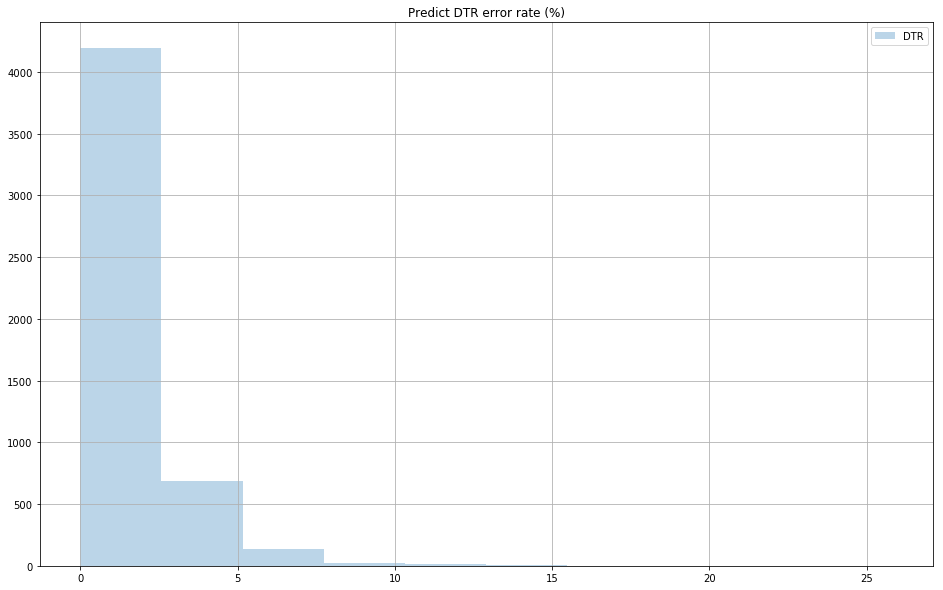

In [25]:
kwargs = dict(histtype='stepfilled', alpha=0.3)

for result in results:
    if result['Accuracy score'] < min_score: continue
    plt.figure(figsize=(16, 10))
    plt.hist(test['Error_PCT_{}'.format(result['Engine'])], **kwargs)
    plt.title("Predict {} error rate (%)".format(result['Engine']))
    plt.grid(True)
    plt.legend([result['Engine']],loc=1)
    plt.show()

>Visually, the polynomial regression looks better than the standard linear regression.

In [26]:
test.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 5062 entries, 2053 to 11625
Data columns (total 18 columns):
Name             5062 non-null object
Age              5062 non-null int64
Photo            5062 non-null object
Nationality      5062 non-null object
Overall          5062 non-null int32
Potential        5062 non-null int64
Club             5062 non-null object
Value            5062 non-null object
Wage             5062 non-null object
Aggression       5062 non-null int64
Crossing         5062 non-null int64
Dribbling        5062 non-null int64
Finishing        5062 non-null int64
Penalties        5062 non-null int64
Stamina          5062 non-null int64
ValueNum         5062 non-null float64
Overall_DTR      5062 non-null float64
Error_PCT_DTR    5062 non-null float64
dtypes: float64(3), int32(1), int64(8), object(6)
memory usage: 731.6+ KB


> As you can see new columns *Overall_[engine]* and *Error_PCR_[engine]* have been added, populated with prediction and error percent rate

In [27]:
o = ['Overall_{}'.format(r['Engine']) for r in results if r['Accuracy score'] > min_score]
e = ['Error_PCT_{}'.format(r['Engine']) for r in results if r['Accuracy score'] > min_score]
t = ['Name', 'Club', 'Age', 'Value', 'Overall', ]
t.extend(o)
t.extend(e)
test[t].nlargest(40, columns=o+e).head(10)


,Name,Club,Age,Value,Overall,Overall_DTR,Error_PCT_DTR
33,K. Mbappé,Paris Saint-Germain,19,€82M,88,92.0,4.545455
216,L. Suárez,FC Barcelona,31,€80M,91,91.0,0.000000
865,S. Handanovič,Inter,33,€30M,88,90.0,2.272727
264,J. Oblak,Atlético Madrid,25,€75.5M,91,89.0,2.197802
84,P. Pogba,Manchester United,25,€73M,88,89.0,1.136364
423,T. Courtois,Real Madrid,26,€47.5M,88,89.0,1.136364
270,P. Aubameyang,Arsenal,29,€59M,88,89.0,1.136364
120,H. Kane,Tottenham Hotspur,24,€96.5M,90,89.0,1.111111
462,S. Agüero,Manchester City,30,€64.5M,89,89.0,0.000000
79,G. Bale,Real Madrid,28,€45M,86,88.0,2.325581


In [28]:
test.loc[
    (test.Age > 21) 
    & (test.Age < 27)
    & (test.ValueNum < 30000000)
    & ((test.Overall_DTR > test.Overall))
    , t ].nsmallest(40, columns=['Error_PCT_DTR']).head(10)

,Name,Club,Age,Value,Overall,Overall_DTR,Error_PCT_DTR
553,E. Forsberg,RB Leipzig,26,€26M,82,83.0,1.219512
83,J. Martínez,Atlanta United,25,€22.5M,81,82.0,1.234568
170,J. Correa,Lazio,23,€20.5M,80,81.0,1.250000
1681,A. Ljajić,Beşiktaş JK,26,€15M,79,80.0,1.265823
223,L. Pellegrini,Roma,22,€18.5M,79,80.0,1.265823
474,M. Dahoud,Borussia Dortmund,22,€17M,79,80.0,1.265823
521,J. Wilshere,West Ham United,26,€14.5M,79,80.0,1.265823
645,L. Alario,Bayer 04 Leverkusen,25,€16M,79,80.0,1.265823
1535,M. Uth,FC Schalke 04,26,€15M,79,80.0,1.265823
851,J. King,Bournemouth,26,€15M,79,80.0,1.265823


In [29]:
dfs = pd.read_html("https://www.skysports.com/premier-league-table", header=0)
df = pd.DataFrame(dfs[0], columns=["Team"])
df.rename(columns={"Team": "Club"}, inplace=True)

In [30]:
ukteams = test[test.Club.isin(df.Club)]

In [31]:
ukteams.loc[
    (ukteams.Age > 20) 
    & (ukteams.Age < 29)
    & (ukteams.ValueNum < 30000000)
    & ((ukteams.Overall_DTR > ukteams.Overall))
    , t ].nsmallest(40, columns=['Error_PCT_DTR']).head(11)

,Name,Club,Age,Value,Overall,Overall_DTR,Error_PCT_DTR
1277,G. Sigurðsson,Everton,28,€22.5M,82,83.0,1.219512
521,J. Wilshere,West Ham United,26,€14.5M,79,80.0,1.265823
851,J. King,Bournemouth,26,€15M,79,80.0,1.265823
795,J. Ward-Prowse,Southampton,23,€14M,78,79.0,1.282051
203,Y. Tielemans,Leicester City,21,€16M,78,79.0,1.282051
842,A. Townsend,Crystal Palace,26,€11M,78,79.0,1.282051
1184,M. Ritchie,Newcastle United,28,€9M,77,78.0,1.298701
1418,N. Mendy,Leicester City,26,€7.5M,76,77.0,1.315789
197,Adama,Wolverhampton Wanderers,22,€8.5M,74,75.0,1.351351
1546,R. Ghezzal,Leicester City,26,€6M,74,75.0,1.351351
